<a href="https://colab.research.google.com/github/Mohamed-Mohamed-Ibrahim/Face-Recognition/blob/main/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load FashionMNIST with transform
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Collect up to 100 samples
X, y = [], []
for image, label in train_dataset:
    if len(X) == 100:
        break
    image_numpy = image.numpy().squeeze()  # (28, 28)
    X.append(image_numpy)
    y.append(label)

# Convert to NumPy and reshape
X = np.array(X).reshape(len(X), -1)  # (100, 784)
y = np.array(y)



# Normalize to [0, 1]
X = X / 255.0

# Explicitly replace infs with nan, then drop all rows with any nans
X[np.isinf(X)] = np.nan
valid_mask = ~np.isnan(X).any(axis=1)
X = X[valid_mask]
y = y[valid_mask]

# Ensure no NaNs or infs remain
assert not np.isnan(X).any(), "NaNs still in X"
assert not np.isinf(X).any(), "Infs still in X"

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"Cleaned X shape: {X.shape}")
print(f"Cleaned y shape: {y.shape}")


Cleaned X shape: (100, 784)
Cleaned y shape: (100,)


In [89]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40)  # Reduce to 50 components (you can adjust this)
print(f"Original shape: {X.shape}")
X = pca.fit_transform(X)

print(f"PCA-reduced shape: {X.shape}")

Original shape: (100, 784)
PCA-reduced shape: (100, 40)


In [90]:
from sklearn.model_selection import train_test_split

# Let's say you already have:
# X_pca: shape (60000, 50)
# y:     shape (60000,)

# Split into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")


Train shape: (80, 40)
Test shape:  (20, 40)


In [111]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import multivariate_normal


class GMM(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=1, tol=0.001, reg_covar=1e-06, max_iter=100, verbose=False, n_init=10):
        self.n_components = n_components
        self.tol = tol
        self.reg_covar = reg_covar
        self.max_iter = max_iter
        self.verbose = verbose
        self.n_init = n_init
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None
        self.cluster_meanings = np.zeros(n_components)

    def fit(self, X):
        best_m = None
        best_c = None
        best_w = None
        best_log_likelihood = -np.inf

        for _ in range(self.n_init):
            self.__fit(X)
            ll = self.score(X)
            if ll > best_log_likelihood:
                best_log_likelihood = ll
                best_m = self.means_
                best_c = self.covariances_
                best_w = self.weights_
            self.means_ = None
            self.covariances_ = None
            self.weights_ = None
        self.means_ = best_m
        self.covariances_ = best_c
        self.weights_ = best_w


    def __fit(self, X):

        n_samples, n_features = X.shape
        self.means_ = np.random.rand(self.n_components, n_features)*20 - 10
        self.covariances_ = np.zeros((self.n_components, n_features, n_features))
        for i in range(self.n_components):
            self.covariances_[i] = np.eye(n_features)
        self.weights_ = (1/self.n_components) + np.zeros(self.n_components)
        log_likelihood_old = -np.inf

        r = np.zeros((self.n_components, n_samples))

        for _ in range(self.max_iter):

            if self.verbose and self.max_iter % 50 == 0:
                print(f"Iteration: {_} -> Means {self.means_} -> Var {self.covariances_} -> Weights {self.weights_}")
            
            # E-step
            # Assign r using posterior probability
            for i in range(self.n_components):
                r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, self.means_[i], self.covariances_[i])

            # Normalization
            for i in range(n_samples):
                r[:, i] = r[:, i] / np.sum(r[:, i])

            old_w = self.weights_.copy()
            old_m = self.means_.copy()
            old_c = self.covariances_.copy()

            # M-step
            for i in range(self.n_components):
                denom = np.sum(r[i, :])
                if denom == 0:
                    continue
                self.weights_[i] = np.sum(r[i, :]) / n_samples

                # for j in range(n_features):
                #     self.means_[i][j] = np.sum(r[i, :] * X[:, j]) / np.sum(r[i, :])
                self.means_[i] = (r[i, :, np.newaxis] * X).sum(axis=0) / np.sum(r[i, :])
                    # for k in range(n_features):
                    #     self.covariances_[i][j, k] = np.sum(r[i, :] * (X[:, j] - self.means_[i][j]) * (X[:, k] - self.means_[i][k])) / np.sum(r[i, :])

                diff = X - self.means_[i]
                self.covariances_[i] = (r[i, :, np.newaxis, np.newaxis] * np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / np.sum(r[i, :])

                # Regularize covariance
                self.covariances_[i] += self.reg_covar * np.eye(n_features)

            if np.all(np.abs(old_w - self.weights_) < self.tol) and np.all(np.abs(old_m - self.means_) < self.tol) and np.all(np.abs(old_c - self.covariances_) < self.tol):
                break
            # log_likelihood_new = self.score(X)
            # if np.abs(log_likelihood_new - log_likelihood_old) < self.tol:
            #     break
            # log_likelihood_old = log_likelihood_new

    def predict(self, X):
        n_samples = len(X)

        r = np.zeros((self.n_components, n_samples))

        for i in range(self.n_components):
            r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, self.means_[i], self.covariances_[i])

        return np.argmax(r, axis=0)

    def score(self, X):
        ll = []
        for d in X:
            tot = 0
            for k in range(self.n_components):
                tot += self.weights_[k] * multivariate_normal.pdf(X, mean=self.means_[k], cov=self.covariances_[k])
            ll.append(np.log(tot))
        return np.sum(ll)

    def clusters_meaning(self, X, y):
        pred = self.predict(X)
        n_pred_clusters = len(
        n_classes = len(np.unique(y))
    
        cluster_map = np.zeros((n_pred_clusters, n_classes), dtype=int)
    
        for i in range(len(X)):
            cluster_map[pred[i], y[i]] += 1
    
        self.cluster_meanings = np.zeros(n_pred_clusters, dtype=int)
        for i, row in enumerate(cluster_map):
            self.cluster_meanings[i] = np.argmax(row)

        

SyntaxError: '(' was never closed (3578662500.py, line 118)

# Testing

/tmp/ipykernel_31/517495981.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], s=30, cmap='viridis')


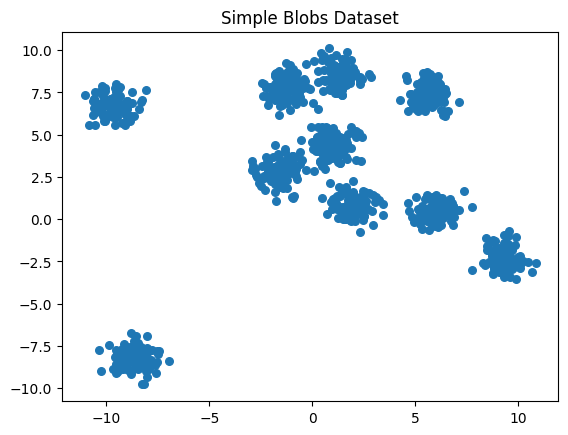

In [98]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate synthetic data
X, y = make_blobs(n_samples=1000, centers=10, cluster_std=0.60, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=30, cmap='viridis')
plt.title("Simple Blobs Dataset")
plt.show()


# Resourses

- https://www.geeksforgeeks.org/how-to-load-fashion-mnist-dataset-using-pytorch/
- https://youtu.be/wT2yLNUfyoM
- https://scikitlearn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
- https://github.com/scikit-learn/scikit-learn/blob/98ed9dc73/sklearn/mixture/_gaussian_mixture.py#L509

# Evaluation

In [95]:
gmm = GaussianMixture(n_components=10, tol=1e-6, max_iter=100)
gmm.fit(X_train)

GaussianMixture(n_components=10, tol=1e-06)

In [96]:
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# Ensure X, y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_components_list = [20, 40, 60]

for n in n_components_list:
    print(f"\n===== n_components = {n} =====")

    # ▶️ Custom GMM
    gmm_custom = GMM(n_components=n, max_iter=50, tol=1e-3, n_init=3, verbose=False)
    gmm_custom.fit(X_train)
    gmm_custom.clusters_meaning(X_train, y_train)
    y_pred_custom = gmm_custom.predict(X_test)
    y_pred_custom_mapped = gmm_custom.cluster_meanings[y_pred_custom]

    acc_custom = accuracy_score(y_test, y_pred_custom_mapped)
    f1_custom = f1_score(y_test, y_pred_custom_mapped, average='macro')

    print("\n[Custom GMM]")
    print(f"Accuracy: {acc_custom:.4f}")
    print(f"F1 Score:  {f1_custom:.4f}")
    print(classification_report(y_test, y_pred_custom_mapped))

    # ▶️ Sklearn GaussianMixture
    gmm_sklearn = GaussianMixture(n_components=n, max_iter=50, tol=1e-3, n_init=3, random_state=42)
    gmm_sklearn.fit(X_train)
    y_pred_sklearn = gmm_sklearn.predict(X_test)

    # Map sklearn GMM clusters to labels
    def map_clusters_to_labels(y_true, clusters):
        from scipy.stats import mode
        labels = np.zeros(np.max(clusters) + 1, dtype=int)
        for i in range(len(labels)):
            mask = clusters == i
            if np.any(mask):
                labels[i] = mode(y_true[mask], keepdims=False).mode
        return labels[clusters]

    y_pred_sklearn_mapped = map_clusters_to_labels(y_train, gmm_sklearn.predict(X_train))[gmm_sklearn.predict(X_test)]

    acc_sklearn = accuracy_score(y_test, y_pred_sklearn_mapped)
    f1_sklearn = f1_score(y_test, y_pred_sklearn_mapped, average='macro')

    print("\n[Sklearn GMM]")
    print(f"Accuracy: {acc_sklearn:.4f}")
    print(f"F1 Score:  {f1_sklearn:.4f}")
    print(classification_report(y_test, y_pred_sklearn_mapped))

    # ▶️ KNN
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)

    acc_knn = accuracy_score(y_test, y_pred_knn)
    f1_knn = f1_score(y_test, y_pred_knn, average='macro')

    print("\n[KNN]")
    print(f"Accuracy: {acc_knn:.4f}")
    print(f"F1 Score:  {f1_knn:.4f}")
    print(classification_report(y_test, y_pred_knn))



===== n_components = 20 =====

[Custom GMM]
Accuracy: 0.1500
F1 Score:  0.0290
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1
           9       0.15      1.00      0.26         3

    accuracy                           0.15        20
   macro avg       0.02      0.11      0.03        20
weighted avg       0.02      0.15      0.04        20


[Sklearn GMM]
Accuracy: 0.1500
F1 Score:  0.0444
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif


[Custom GMM]
Accuracy: 0.1500
F1 Score:  0.0317
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1
           9       0.17      1.00      0.29         3

    accuracy                           0.15        20
   macro avg       0.02      0.11      0.03        20
weighted avg       0.03      0.15      0.04        20



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[Sklearn GMM]
Accuracy: 0.0500
F1 Score:  0.0444
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.33      0.50      0.40         2
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         3

    accuracy                           0.05        20
   macro avg       0.04      0.06      0.04        20
weighted avg       0.03      0.05      0.04        20


[KNN]
Accuracy: 0.4500
F1 Score:  0.4804
              precision    recall  f1-score   support

           0       0.20      0.50      0.29         2
           1       1.00      1.00      1.00         1
           2       0.50      0.50      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[Custom GMM]
Accuracy: 0.1000
F1 Score:  0.0202
              precision    recall  f1-score   support

           0       0.10      1.00      0.18         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         3

    accuracy                           0.10        20
   macro avg       0.01      0.11      0.02        20
weighted avg       0.01      0.10      0.02        20



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[Sklearn GMM]
Accuracy: 0.0000
F1 Score:  0.0000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       2.0
           3       0.00      0.00      0.00       3.0
           4       0.00      0.00      0.00       2.0
           5       0.00      0.00      0.00       2.0
           6       0.00      0.00      0.00       4.0
           7       0.00      0.00      0.00       1.0
           8       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       3.0

    accuracy                           0.00      20.0
   macro avg       0.00      0.00      0.00      20.0
weighted avg       0.00      0.00      0.00      20.0


[KNN]
Accuracy: 0.4500
F1 Score:  0.4804
              precision    recall  f1-score   support

           0       0.20      0.50      0.29         2
           1       1.00      1.00      1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

# Fine Tuning 

In [ ]:
print(gmm.predict(X_train))
print(y_train)
gmm.clusters_meaning(X_train, y_train)
print(gmm.cluster_meanings[gmm.predict(X_train)])
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
accuracy_score(gmm.cluster_meanings[gmm.predict(X_train)], y_train)

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GMM(n_components=10, tol=1e-6, max_iter=100, n_init=100)
gmm.fit(X)
labels = gmm.predict(X)



plt.scatter(X[:, 0], X[:, 1], c=labels, s=15, cmap='viridis')
plt.title("GMM Clustering Result")
plt.show()


In [22]:
from sklearn.model_selection import GridSearchCV

gmmfm = GMM()

parameters = {
    'n_components': [1, 2, 3, 4],
    'tol': [1e-3, 1e-4],
    'reg_covar': [1e-6, 1e-5],
    'max_iter': [100],
    'n_init': [1, 5]
}

clf = GridSearchCV(gmmfm, parameters)

clf.fit(X)

GridSearchCV(estimator=GMM(),
             param_grid={'max_iter': [100], 'n_components': [1, 2, 3, 4],
                         'n_init': [1, 5], 'reg_covar': [1e-06, 1e-05],
                         'tol': [0.001, 0.0001]})

In [23]:
sorted(clf.best_params_.items())

[('max_iter', 100),
 ('n_components', 4),
 ('n_init', 5),
 ('reg_covar', 1e-06),
 ('tol', 0.0001)]

In [72]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Make predictions
y_pred = clf.predict(X)

# Evaluate accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

NameError: name 'clf' is not defined